# Import appropriate packages

In [171]:
## Packages for data collection, exploration, and modeling
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

## Web Scraping Packages
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests
import time
import random
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chromedriver = "/Users/Carter/Desktop/chromedriver"

## to fill in missing data
from fancyimpute import KNN

## Plotting
import seaborn as sns
%matplotlib inline

## Notice: You will notice some of the data collection cells have not been run in this notebook.  That is because I completed them in a separate notebook and then copied them here for submission.

# Part 1- Data Collection and introduction to Web Scraping


In [151]:
# initiate webdrive and add extension that blocks ads.  This increases the speed of how fast
# each html page loads
chop = webdriver.ChromeOptions()
chop.add_extension('/Users/Carter/Desktop/Adblock-Plus_v1.13.2.crx')

### Part 1 Step 1: Scrape to get URL's of all basketball players on website
#### Takes ~45 minutes to run on my machine

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

#empty array where we will store player data
player_links = []

page_letters = list("abcdefghijklmnopqrstuvwxyz")

for letter in page_letters:
    
    url = "http://www.basketball-reference.com/players/%s/" % letter
    
    browser.get(url)
    
    html = browser.page_source
    
    # grab inactive players without the strong html tag
    links = Selector(text=html).xpath("//th[@class='left ']/a/@href").extract()
    
    # then grap active players with the strong html tag
    links1 = Selector(text=html).xpath("//th[@class='left ']/strong/a/@href").extract()
    
    #combine the two separate links into one
    links = links + links1
   
    player_links.append(links)
    
    # set up random time interval to mitigate risk of being blocked by the domain
    time.sleep(2*np.random.rand())

browser.quit()

In [ ]:
# create a test links to validate data collection
test_list = player_links[:]

In [ ]:
import itertools
list2d = test_list
merged = list(itertools.chain(*list2d))

# verify list is accurate in terms of length comparted to what the website says.
# will use this link list for data collection on each player
player_links = merged[:]
len(player_links)

### Part 1 Step 2: Iterate through all links to grab each players Stats- NBA general stats, NBA advanced stats, and (if present) College Stats
#### Takes ~3hrs on my machine to run

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

player_stats = []

print datetime.datetime.now().time()

for l in player_links:
    
    player_url = "http://www.basketball-reference.com%s" % l
    
    # get the html of the player page
    browser.get(player_url)
    
    # pull the page source so I can access the data via xpath selector
    player_html = browser.page_source
    
    # grab the name of the player
    name = Selector(text=player_html).xpath("//h1/text()").extract()
    
    # check if 'college' appears on their page
    college = Selector(text=player_html).xpath("//div[@id='all_all_college_stats']/div[@class='section_heading']//h2/text()").extract()
    if not college:
        pass
    else:
    
        player_stats.append({
            "Name": name[0],
            "Lg": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='lg_id']/text()").extract(),
            "G": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='g']/text()").extract(),
            "GS": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='gs']/text()").extract(),
            "MP": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='mp_per_g']/text()").extract(),
            "FG": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg_per_g']/text()").extract(),
            "FGA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fga_per_g']/text()").extract(),
            "FG%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg_pct']/text()").extract(),
            "3P": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3_per_g']/text()").extract(),
            "3PA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3a_per_g']/text()").extract(),
            "3P%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3_pct']/text()").extract(),
            "2P": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2_per_g']/text()").extract(),
            "2PA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2a_per_g']/text()").extract(),
            "2P%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2_pct']/text()").extract(),
            "eFG%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='efg_pct']/text()").extract(),
            "FT": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ft_per_g']/text()").extract(),
            "FTA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fta_per_g']/text()").extract(),
            "FT%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ft_pct']/text()").extract(),
            "ORB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='orb_per_g']/text()").extract(),
            "DRB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='drb_per_g']/text()").extract(),
            "TRB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='trb_per_g']/text()").extract(),
            "AST": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ast_per_g']/text()").extract(),
            "STL": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='stl_per_g']/text()").extract(),
            "BLK": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='blk_per_g']/text()").extract(),
            "TOV": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='tov_per_g']/text()").extract(),
            "PF": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='pf_per_g']/text()").extract(),
            "PTS": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='pts_per_g']/text()").extract(),
            "PER": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='per']/text()").extract(),
            "TS%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ts_pct']/text()").extract(),
            "3PAr": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='fg3a_per_fga_pct']/text()").extract(),
            "FTr": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='fta_per_fga_pct']/text()").extract(),
            "ORB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='orb_pct']/text()").extract(),
            "DRB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='drb_pct']/text()").extract(),
            "TRB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='trb_pct']/text()").extract(),
            "AST%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ast_pct']/text()").extract(),
            "STL%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='stl_pct']/text()").extract(),
            "BLK%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='blk_pct']/text()").extract(),
            "TOV%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='tov_pct']/text()").extract(),
            "USG%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='usg_pct']/text()").extract(),
            "OWS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ows']/text()").extract(),
            "DWS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='dws']/text()").extract(),
            "WS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ws']/text()").extract(),
            "WS/48": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ws_per_48']/text()").extract(),
            "OBPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='obpm']/text()").extract(),
            "DBPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='dbpm']/text()").extract(),
            "BPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='bpm']/text()").extract(),
            "VORP": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='vorp']/text()").extract()
            "G": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='g']/text()").extract(),
            "MP": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='mp']/text()").extract(),
            "FG": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg']/text()").extract(),
            "FGA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fga']/text()").extract(),
            "3P": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3']/text()").extract(),
            "3PA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3a']/text()").extract(),
            "FT": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ft']/text()").extract(),
            "FTA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fta']/text()").extract(),
            "ORB": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='orb']/text()").extract(),
            "TRB": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='trb']/text()").extract(),
            "AST": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ast']/text()").extract(),
            "STL": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='stl']/text()").extract(),
            "BLK": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='blk']/text()").extract(),
            "TOV": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='tov']/text()").extract(),
            "PF": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pf']/text()").extract(),
            "PTS": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pts']/text()").extract(),
            "FG%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg_pct']/text()").extract(),
            "3P%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3_pct']/text()").extract(),
            "FT%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ft_pct']/text()").extract(),
            "MP_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='mp_per_g']/text()").extract(),
            "PTS_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pts_per_g']/text()").extract(),
            "TRB_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='trb_per_g']/text()").extract(),
            "AST_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ast_per_g']/text()").extract()
            })
    
    # put in random alert ot make sure program is still functioning correctly
    chance = (random.randint(1,100))    
    if chance <= 1:
        print ("1% chance of getting this-- still running")

print datetime.datetime.now().time()
browser.quit()

In [ ]:
# save uncleaned dataframe just in case-- this will make it so I wont have to run scrape program
# again unnecessarily
df = pd.DataFrame(player_stats)
df.shape

df.to_csv(path_or_buf= 'pro_players_v1.csv')

In [ ]:
# start work to clean up player stats
v1 = player_stats[:]

In [ ]:
# function to clean up data
for index, row in enumerate(v1):
    
    for key, value in row.items():
        
        if len(value) < 1:
            v1[index][key] = ""
        elif type(value) == list:
            v1[index][key] = value[0]
        else:
            v1[index][key] = value

In [ ]:
# cleaner dataframe now
df2 = pd.DataFrame(v1)
df2.shape

df2.to_csv(path_or_buf= 'pro_players_v2.csv')

## End of copying the other Jupyter notebook into this one

#### Reading in data that was collected in other jupyter notebook and saved into CSV files

In [31]:
nba = pd.read_csv('old/players_combined.csv')

In [32]:
college = pd.read_csv('old/college_stats.csv')

In [33]:
position = pd.read_csv('old/player_positions.csv')

In [34]:
holder = []
for x in position['Position']:
    if type(x) == float:
        holder.append(str(x))
    else:
        holder.append(x)

position['Position'] = holder

In [35]:
position['Position']= position['Position'].apply(lambda x: x.replace("C-PF", "C").replace("PF-C", "C").replace("PF-SF", "PF").replace("PG-SG", "PG").replace("SF-PF", "SF").replace("SF-SG", "SG").replace("SG-PG", "PG").replace("SG-SF", "SG"))

In [36]:
position.groupby('Position').count()

,Unnamed: 0,Name
Position,,
C,700,700
PF,786,786
PG,713,713
SF,820,820
SG,890,890
nan,551,551


In [37]:
df_position = pd.get_dummies(position['Position'])

In [38]:
df_position.head()

,C,PF,PG,SF,SG,nan
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,1,0


In [39]:
pos_final = pd.concat([position, df_position], axis=1)

#### Add prefix on college stats to differentiate after merge

In [40]:
college.add_prefix('[C]')
college = college.rename(columns={'[C]Name': 'Name'})

### Add position DF to NBA DF

In [41]:
nba = pd.merge(nba, pos_final, on='Name', how='left')

In [42]:
nba.to_csv(path_or_buf= 'carter-working.csv')

### Inner join two files to get less missing data

In [43]:
print nba.shape
print college.shape

(4761, 56)
(2622, 25)


In [44]:
df_inner = pd.merge(nba, college, on='Name', how='inner', suffixes=('_NBA', '_C'))

In [45]:
df_inner.shape

(3168, 80)

In [46]:
df_inner.to_csv(path_or_buf='df_inner.csv')

In [47]:
(len(df_inner)*0.05)

158.4

## Fill missing values of column if less than 40% of values are missing.  Replace with average value BY POSITION of that column.  I need to take this measure to run models 

In [49]:
for col in df_inner.columns:
    nulnum = df_inner[col].isnull().sum() 
#     print col, nulnum
    if 0 < nulnum <= (len(df_inner)*.40):
        df_inner[col].fillna(df_inner.groupby('Position')[col].transform("mean"), inplace=True)
    

### Dropping the rest of the columns that did not make cut in terms of percentage of missing data

In [50]:
data = df_inner.drop(['ORB_C', 'PF', 'TOV_C', 'Name', 'Lg'], axis=1)

In [51]:
data = data.fillna(0)

In [52]:
data.to_csv(path_or_buf='data.csv')

In [53]:
data = data.drop('Unnamed: 0_x', 1)

In [54]:
data = data.drop('Unnamed: 0_y', 1)

In [55]:
columns ={
    '2P': '2P_NBA',
    '2P%': '2P%_NBA',
    '2PA': '2PA_NBA',
    'DRB': 'DRB_NBA',
    'GS': 'GS_NBA',
    'PF_x': 'PF_NBA',
    'eFG%': 'eFG%_NBA',
    '3PAr': '3PAr_NBA',
    'AST%': 'AST%_NBA',
    'BLK%': 'BLK%_NBA',
    'BPM': 'BPM_NBA',
    'DBPM': 'DBPM_NBA',
    'DRB%': 'DRB%_NBA',
    'DWS': 'DWS_NBA',
    'FTr': 'FTr_NBA',
    'OBPM': 'OBPM_NBA',
    'ORB%': 'ORB%_NBA',
    'OWS': 'OWS_NBA',
    'PER': 'PER_NBA',
    'STL%': 'STL%_NBA',
    'TOV%': 'TOV%_NBA',
    'TRB%':'TRB%_NBA',
    'TS%': 'TS%_NBA',
    'USG%': 'USG%_NBA',
    'VORP': 'VORP_NBA',
    'WS': 'WS_NBA',
    'WS/48': 'WS/48_NBA',
    'PF_y': 'PF',
    'AST_per_g': 'AST_per_g_C',
    'MP_per_g': 'MP_per_g_C',
    'PTS_per_g':'PTS_per_g_C' ,
    'TRB_per_g': 'TRB_per_g_C'
}

In [56]:
data = data.rename(columns=columns)

In [58]:
data.to_csv(path_or_buf='data_final.csv')

In [28]:
### Just in case - can read in dataset directly from here with completed cleanup

In [29]:
# data = pd.read_csv('data_final.csv')

In [150]:
data.shape

(3168, 73)

In [ ]:
loc[data['Position'] == 'nan']

In [151]:
data = data[data.Position != 'nan']

In [153]:
data.shape

(3168, 73)

In [155]:
Y1 = data['PER_NBA']

In [156]:
Y1.describe()

count    3168.000000
mean       11.792165
std         6.027877
min       -46.600000
25%         9.400000
50%        12.000000
75%        14.500000
max        88.300000
Name: PER_NBA, dtype: float64

In [154]:
X1 = data[['C','PF','PG','SF','SG','nan','3P_C','3P%_C','3PA_C','AST_C','AST_per_g_C','BLK_C','FG_C','FG%_C','FGA_C','FT_C','FT%_C','FTA_C','G_C', 'MP_C','MP_per_g_C','PTS_C','PTS_per_g_C','STL_C','TRB_C','TRB_per_g_C']]

In [157]:
print Y1.shape
print X1.shape

(3168,)
(3168, 26)


In [158]:
df = pd.concat([Y1, X1], axis=1)

In [159]:
df.shape

(3168, 27)

In [61]:
# y = data['PER']

In [62]:
# X = data.drop('PER', axis=1)

In [147]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Left join two files to get larger amount of rows, but more missing data

In [45]:
#df_left = pd.merge(nba, college, on='Name', how='left')

In [46]:
#df_left.shape

(4671, 72)

In [23]:
#df_left.to_csv(path_or_buf='df_left.csv')

In [50]:
#df_left = df_left.dropna(axis= 0, how='all')

In [51]:
#df_left.shape

(4671, 72)

# Part 2: EDA- Initial Exploration of the Data 

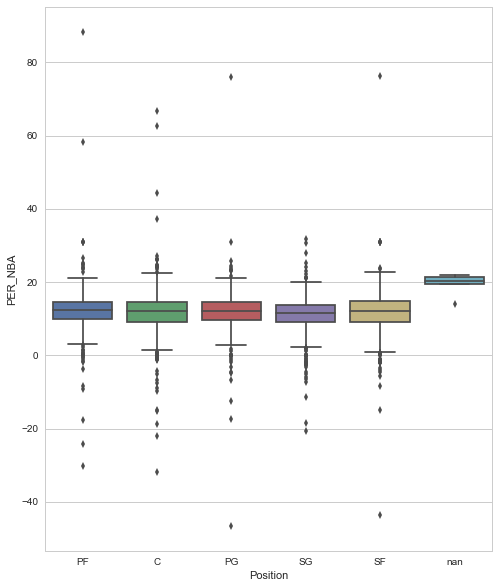

In [105]:
plt.figure(figsize=(8,10))
sns.set_style("whitegrid")

plot1 = sns.boxplot(x="Position", y="PER_NBA", data=df)
boxplot = plot1.get_figure()
boxplot.savefig("boxplot.png")


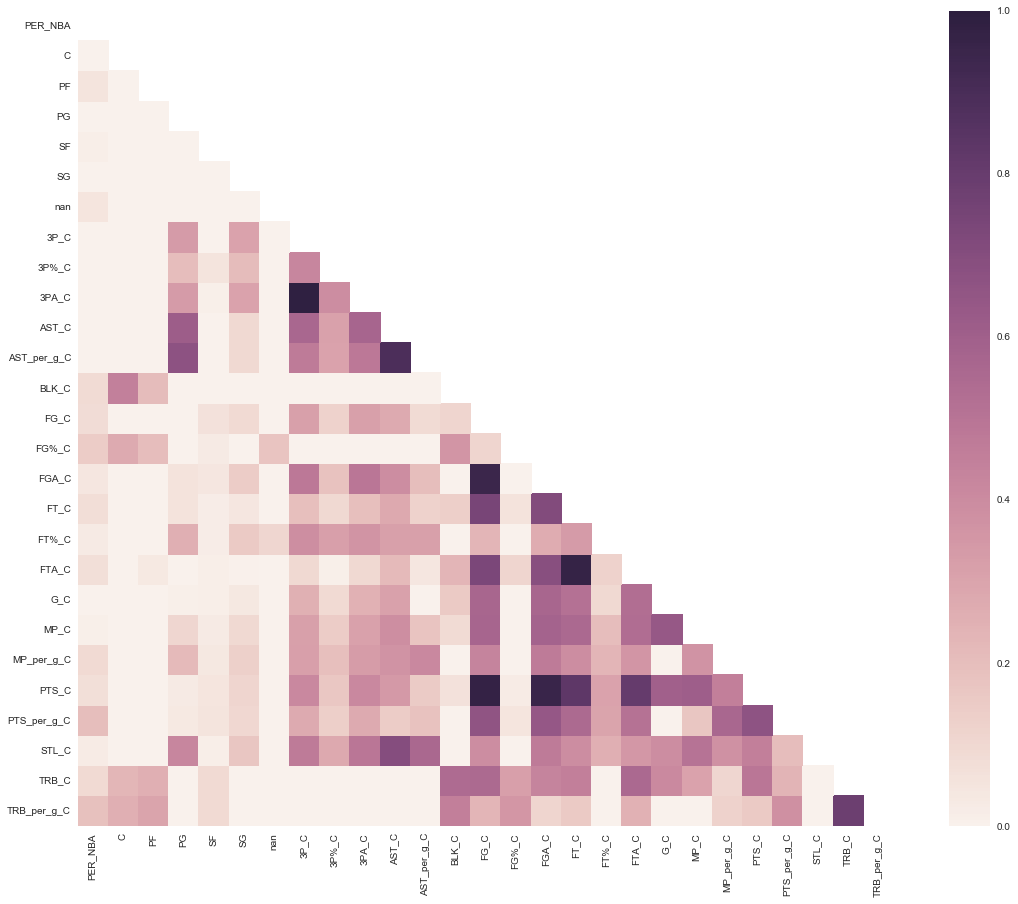

In [121]:
corrmat = df.corr(method='pearson')

fig = plt.figure(figsize=(20,15))

ax= fig.gca()

mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax= sns.heatmap(corrmat, vmin=0, vmax=1, square=True, mask=mask)

heatmap = ax.get_figure()
heatmap.savefig("heatmap.png")


In [13]:
### Inital Regression

In [161]:
model = sm.OLS(Y1, X1, missing='drop')
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                PER_NBA   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     13.03
Date:                Wed, 19 Apr 2017   Prob (F-statistic):           3.49e-51
Time:                        16:10:38   Log-Likelihood:                -10029.
No. Observations:                3168   AIC:                         2.011e+04
Df Residuals:                    3142   BIC:                         2.027e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
C               3.0779      2.545      1.209      

### Start Regularization via Lasso Regression

In [190]:
# Create a function called lasso,
def lasso(alphas):
   
    reg = pd.DataFrame()
    reg['Feature Name'] = X1.columns.tolist()
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)

        lasso.fit(X1, Y1)

        column_name = 'Alpha = %f' % alpha

        reg[column_name] = lasso.coef_

    return reg

In [195]:
lasso([0.001, 0.05, .1])

,Feature Name,Alpha = 0.001000,Alpha = 0.050000,Alpha = 0.100000
0,C,-0.404781,-0.000000,-0.000000
1,PF,0.210008,0.053529,0.000000
2,PG,0.373133,0.000000,0.000000
3,SF,-0.000000,-0.000000,-0.000000
4,SG,-0.358975,-0.233615,-0.000000
5,nan,7.493694,0.000000,0.000000
6,3P_C,0.005063,0.005586,0.004606
7,3P%_C,0.550421,0.000000,-0.000000
8,3PA_C,-0.002385,-0.002596,-0.002413
9,AST_C,-0.002951,0.000814,0.000995


### Does SK Learn yield different results?

In [196]:
lm = linear_model.LinearRegression(normalize=True).fit(X1, Y1)
print metrics.mean_squared_error(Y1, lm.predict(X1)), lm.score(X1, Y1)


32.9117560711 0.0939348771404


### What about different types of Regressions?

In [197]:
lm = linear_model.LinearRegression().fit(X1, Y1)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(Y1, lm.predict(X1))
print 'OLS R2:', lm.score(X1, Y1)

lm = linear_model.Lasso().fit(X1, Y1)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(Y1, lm.predict(X1))
print 'Lasso R2:', lm.score(X1, Y1)

lm = linear_model.Ridge().fit(X1, Y1)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(Y1, lm.predict(X1))
print 'Ridge R2:', lm.score(X1, Y1)

~~~ OLS ~~~
OLS MSE:  32.9110623756
OLS R2: 0.093953974672
~~~ Lasso ~~~
Lasso MSE:  33.5062652746
Lasso R2: 0.0775679578749
~~~ Ridge ~~~
Ridge MSE:  32.9192158718
Ridge R2: 0.0937295078126


### Grid Search 

In [198]:
from sklearn import grid_search

alphas = np.logspace(-1, 1, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(X1, Y1)


/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  0.1    ,   0.12589,   0.15849,   0.19953,   0.25119,   0.31623,
         0.39811,   0.50119,   0.63096,   0.79433,   1.     ,   1.25893,
         1.58489,   1.99526,   2.51189,   3.16228,   3.98107,   5.01187,
         6.30957,   7.94328,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [200]:
print -gs.best_score_ 
print gs.best_estimator_ 

33.9430217148
Ridge(alpha=3.1622776601683795, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)


In [242]:
gs.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': None,
 'estimator__normalize': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.001,
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'alpha': array([  0.1       ,   0.12589254,   0.15848932,   0.19952623,
           0.25118864,   0.31622777,   0.39810717,   0.50118723,
           0.63095734,   0.79432823,   1.        ,   1.25892541,
           1.58489319,   1.99526231,   2.51188643,   3.16227766,
           3.98107171,   5.01187234,   6.30957344,   7.94328235,  10.        ])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': 'mean_squared_error',
 'verbose': 0}

In [202]:
gs.best_estimator_.coef_

array([ -1.27620312e+00,  -6.61690768e-01,  -5.36447317e-01,
        -9.17592193e-01,  -1.28318995e+00,   4.67512335e+00,
         5.30686256e-03,   4.01697633e-01,  -2.38330919e-03,
        -2.43446306e-03,   3.08722425e-01,   7.43828134e-03,
         5.20220001e-03,   5.30311653e+00,  -1.82867347e-03,
         6.66616748e-03,  -3.20372411e-01,  -5.20387903e-03,
        -1.49650163e-02,   4.11932083e-04,  -4.21338250e-02,
        -5.87964231e-04,   1.73668519e-01,   1.11827939e-02,
        -2.69736836e-03,   4.30262728e-01])

In [243]:
pd.DataFrame({'features':X1.columns,'coef':gs.best_estimator_.coef_, 'abs_coef':abs(gs.best_estimator_.coef_)}).sort_values('abs_coef', ascending=False)

,abs_coef,coef,features
13,5.303117,5.303117,FG%_C
5,4.675123,4.675123,nan
4,1.283190,-1.283190,SG
0,1.276203,-1.276203,C
3,0.917592,-0.917592,SF
1,0.661691,-0.661691,PF
2,0.536447,-0.536447,PG
25,0.430263,0.430263,TRB_per_g_C
7,0.401698,0.401698,3P%_C
16,0.320372,-0.320372,FT%_C


In [31]:
from sklearn import preprocessing
from sklearn import utils



### Due to fact that data set has so many variables, attempting PCA so reduce multicollinearity

In [80]:
# yknn = y.astype('int')

In [244]:
## knn on original dataset, more just to see 

# knn = KNeighborsClassifier(n_neighbors=10)
# cross_val_score(knn, X, yknn, cv=3, scoring='accuracy').mean()

## not sure why its so low compared to to other linear regression models

In [205]:
X1.shape

(3168, 26)

In [249]:
from sklearn import decomposition

print "initial shape: ", X1.shape
pca = decomposition.PCA(n_components=3)
X_r = pca.fit_transform(X1)

print "new feature data after PCA: ", X_r.shape

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

initial shape:  (3168, 26)
new feature data after PCA:  (3168, 3)
explained variance ratio (first two components): [ 0.7319853   0.16661581  0.06267287]


In [250]:
X_r

array([[  773.95248495,    71.89474718,    80.35315136],
       [ -481.09023236,  1228.78018113,   625.36250544],
       [ -109.24244205,   581.50111416,  -538.80383648],
       ..., 
       [  693.22216415,    11.08249183,   188.86010583],
       [  -20.01635243,   170.95624036,   348.201547  ],
       [ 2504.73188409,   -87.54471194,    -7.24505657]])

In [251]:
pca.explained_variance_
# below are eigan values


array([ 1184573.06380354,   269634.65243868,   101423.61130392])

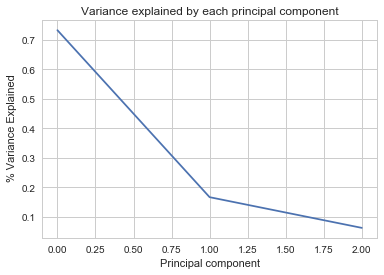

In [252]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance explained by each principal component')
plt.ylabel(' % Variance Explained')
plt.xlabel('Principal component')

In [253]:
X_reconstituted = pca.inverse_transform(X_r)


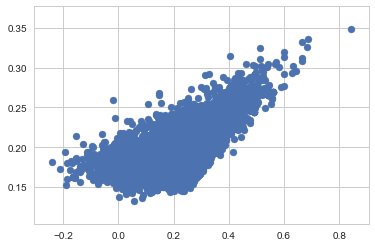

In [254]:
plt.scatter(X_reconstituted[:,1], X_reconstituted[:,3])

### Knn with PCA'd data

In [91]:
knn = KNeighborsClassifier(n_neighbors=10)
cross_val_score(knn, X_r, yknn, cv=3, scoring='accuracy').mean()

0.084150227920707102

##### Curious Comparsion of regression with PCA'd data

In [85]:
lm = linear_model.LinearRegression().fit(X_r, y)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(y, lm.predict(X_r))
print 'OLS R2:', lm.score(X_r, y)

lm = linear_model.Lasso().fit(X_r, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(X_r))
print 'Lasso R2:', lm.score(X_r, y)

lm = linear_model.Ridge().fit(X_r, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(X_r))
print 'Ridge R2:', lm.score(X_r, y)

~~~ OLS ~~~
OLS MSE:  31.5125442852
OLS R2: 0.174755132888
~~~ Lasso ~~~
Lasso MSE:  31.5125560829
Lasso R2: 0.174754823932
~~~ Ridge ~~~
Ridge MSE:  31.5125442852
Ridge R2: 0.174755132888
